# Import necessary libraries

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import glob
from scipy import stats
from math import radians, cos, sin, asin, sqrt

# Import csv files

In [2]:
# Removed files with 0mb and also 2019. We want to know 2020-10 tm 2020-12 for now.
files = glob.glob(r'GVB/*.csv')
gvb_data = pd.concat( (pd.read_csv(file, sep=";") for file in files), ignore_index = True)
gvb_data

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
0,10/31/2020 12:00:00 AM,18:00 - 18:59,NaN,Overig,NaN,NaN,1
1,11/30/2020 12:00:00 AM,00:00 - 00:59,NaN,Overig,NaN,NaN,4
2,11/30/2020 12:00:00 AM,01:00 - 01:59,NaN,Overig,NaN,NaN,53
3,11/30/2020 12:00:00 AM,02:00 - 02:59,NaN,Overig,NaN,NaN,49
4,11/30/2020 12:00:00 AM,03:00 - 03:59,NaN,Overig,NaN,NaN,30
...,...,...,...,...,...,...,...
3303773,10/24/2021 12:00:00 AM,23:00 - 23:59,WLP,Waterlooplein,4.902982,52.366979,47
3303774,10/24/2021 12:00:00 AM,23:00 - 23:59,WPP,Weesperplein,4.907875,52.361201,53
3303775,10/24/2021 12:00:00 AM,23:00 - 23:59,WTC,Station Zuid,4.875099,52.339080,213
3303776,10/25/2021 12:00:00 AM,00:00 - 00:59,[[ Onb,[[ Onbekend ]],0.000000,0.000000,189


In [3]:
# Read Resono data for later
resono = pd.read_csv("resono_2020_2022.csv")
resono

,Unnamed: 0,Location,End,Visits,End_Dates,End_Time
0,0,Erasmuspark,2020-09-30 00:15:00,71,2020-09-30,00:15:00
1,1,Erasmuspark,2020-09-30 00:30:00,56,2020-09-30,00:30:00
2,2,Erasmuspark,2020-09-30 00:45:00,41,2020-09-30,00:45:00
3,3,Erasmuspark,2020-09-30 01:00:00,55,2020-09-30,01:00:00
4,4,Erasmuspark,2020-09-30 01:15:00,33,2020-09-30,01:15:00
...,...,...,...,...,...,...
378412,378412,Westerpark West,2022-01-06 13:45:00,116,2022-01-06,13:45:00
378413,378413,Westerpark West,2022-01-06 14:00:00,107,2022-01-06,14:00:00
378414,378414,Westerpark West,2022-01-06 14:15:00,112,2022-01-06,14:15:00
378415,378415,Westerpark West,2022-01-06 14:30:00,114,2022-01-06,14:30:00


# Preprocess GVB data

In [4]:
# Set dates to datetime
# Only select data from 10-2020 till 12-2021
# Drop if destination is unknown
# Remove NaN and [[ Onbekend ]] values
gvb_data['Datum'] = pd.to_datetime(gvb_data['Datum'])
gvb_data = gvb_data.sort_values(by=['Datum', 'UurgroepOmschrijving (van aankomst)'])
gvb_data_range = gvb_data[(gvb_data['Datum'] >= '2020-10-1') & (gvb_data['Datum'] <= '2021-12-31')]
gvb_data_range_cleaned = gvb_data_range[gvb_data_range['AankomstHalteCode'].notnull()]
gvb_data_range_cleaned = gvb_data_range_cleaned[gvb_data_range_cleaned['AankomstHalteNaam'] != "[[ Onbekend ]]"]
gvb_data_range_cleaned.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
244710,2020-10-01,00:00 - 00:59,05022,Centraal Station,4.901043,52.377720,14
244711,2020-10-01,00:00 - 00:59,08247,Vennepluimstraat,4.990572,52.357697,11
244712,2020-10-01,00:00 - 00:59,ASA,Amstelstation,4.917514,52.346473,28
244713,2020-10-01,00:00 - 00:59,ASW,Amstelveenseweg,4.857983,52.338367,12


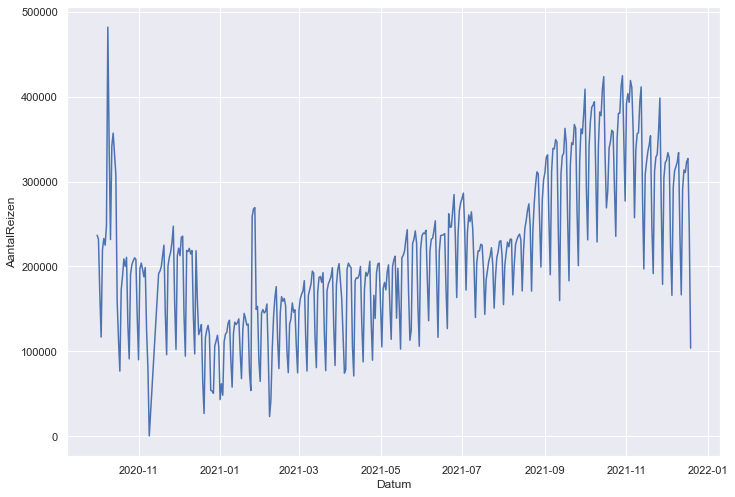

In [5]:
gvb_data_range_cleaned_travellers_per_day = gvb_data_range_cleaned.groupby(['Datum']).sum().reset_index()
gvb_data_range_cleaned_travellers_per_day.head()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_cleaned_travellers_per_day);

<AxesSubplot:xlabel='Datum', ylabel='count'>

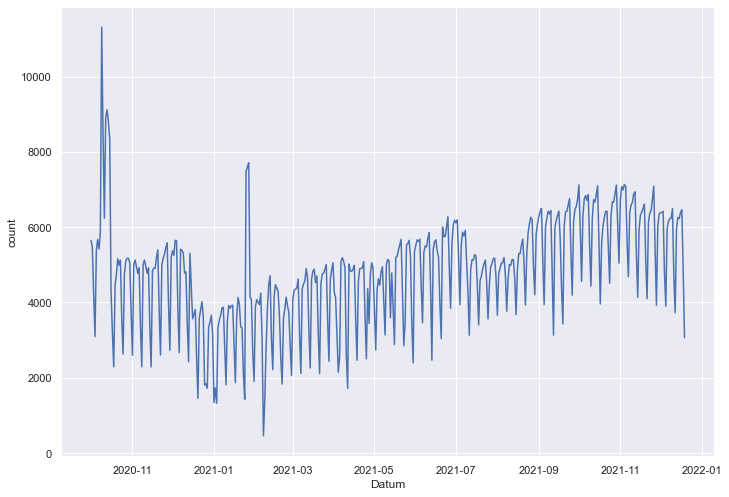

In [66]:
# The line above is misleading, it's mainly because of missing data.
gvb_data_range_very_cleaned_count = gvb_data_range_very_cleaned
gvb_data_range_very_cleaned_count['count'] = 1
gvb_data_range_very_cleaned_count = gvb_data_range_very_cleaned_count.groupby('Datum').sum()

sns.lineplot(data=gvb_data_range_very_cleaned_count.reset_index(), x='Datum', y="count")

In [97]:
# Strange, there seems to be missing data 2020-11-08, let's check this. 395 is very very low, so let's replace
# this outlier with one week before
gvb_data_range_cleaned_travellers_per_day.set_index('Datum').loc["2020-11-09"]

AankomstLat      113.048821
AankomstLon     1204.008159
AantalReizen     395.000000
Name: 2020-11-09 00:00:00, dtype: float64

In [7]:
# Replace missing data with one week before
gvb_data_range_cleaned_without_9_november = gvb_data_range_cleaned[gvb_data_range_cleaned['Datum'] != "2020-11-09"]
gvb_week46 = gvb_data_range_cleaned[(gvb_data_range_cleaned['Datum'] >= '2020-11-02') & (gvb_data_range_cleaned['Datum'] <= '2020-11-08')]
gvb_week46['Datum'] = gvb_week46["Datum"] + dt.timedelta(days=7)
frames = [gvb_data_range_cleaned_without_9_november, gvb_week46]
gvb_data_range_very_cleaned = pd.concat(frames)
gvb_data_range_very_cleaned.sort_values(by="Datum", inplace=True)

gvb_data_range_very_cleaned                            

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554
...,...,...,...,...,...,...,...
2664027,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31
2664028,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14
2664029,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20
2664020,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14


In [92]:
# Still a lot of values are missing, make sure every data point gets added and interpolated
# take last hour from column UurgroepOmschrijving and convert to datetime
# add one minute to get hour, so 17:00 means 16:00 - 16:59
# cmobine date and hour to make index unique
gvb_data_range_very_cleaned_interpolation = gvb_data_range_very_cleaned.copy()
gvb_data_range_very_cleaned_interpolation['hour'] = pd.to_datetime(gvb_data_range_very_cleaned_interpolation['UurgroepOmschrijving (van aankomst)'].str[-5:])
gvb_data_range_very_cleaned_interpolation['hour'] = gvb_data_range_very_cleaned_interpolation['hour'].dt.time
gvb_data_range_very_cleaned_interpolation['date'] = gvb_data_range_very_cleaned_interpolation.apply(lambda r : pd.datetime.combine(r['Datum'],r['hour']),1)


In [98]:
gvb_data_range_very_cleaned_interpolation.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen,count,hour,date
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22,1,00:59:00,2020-10-01 00:59:00
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139,1,16:59:00,2020-10-01 16:59:00
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261,1,16:59:00,2020-10-01 16:59:00
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205,1,16:59:00,2020-10-01 16:59:00
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554,1,16:59:00,2020-10-01 16:59:00


# EDA GVB
## big assumption: missing values 09-11-2020 - 15-11-2020 by week before
### 1. Mean 214.273 journeys a day
### 2. peak in october
### 3. every sunday less visitors

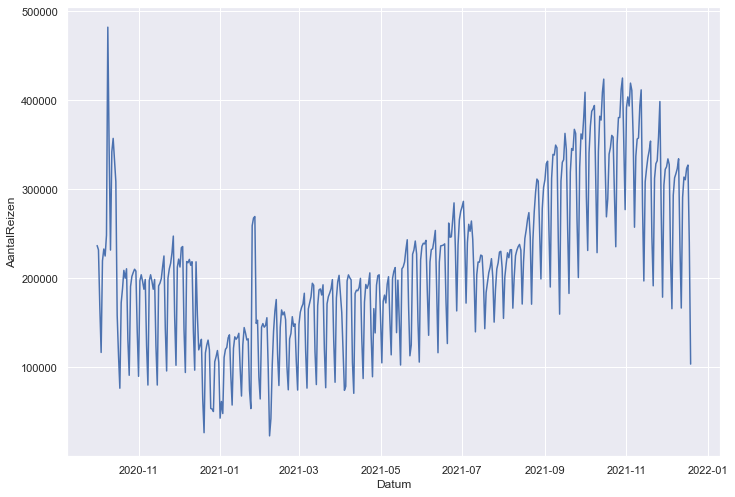

In [9]:
# travels per day in 2020-10 - 2020-12 period
gvb_data_range_very_cleaned_travellers_per_day = gvb_data_range_very_cleaned_interpolation.groupby(['Datum']).sum().reset_index()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_very_cleaned_travellers_per_day);

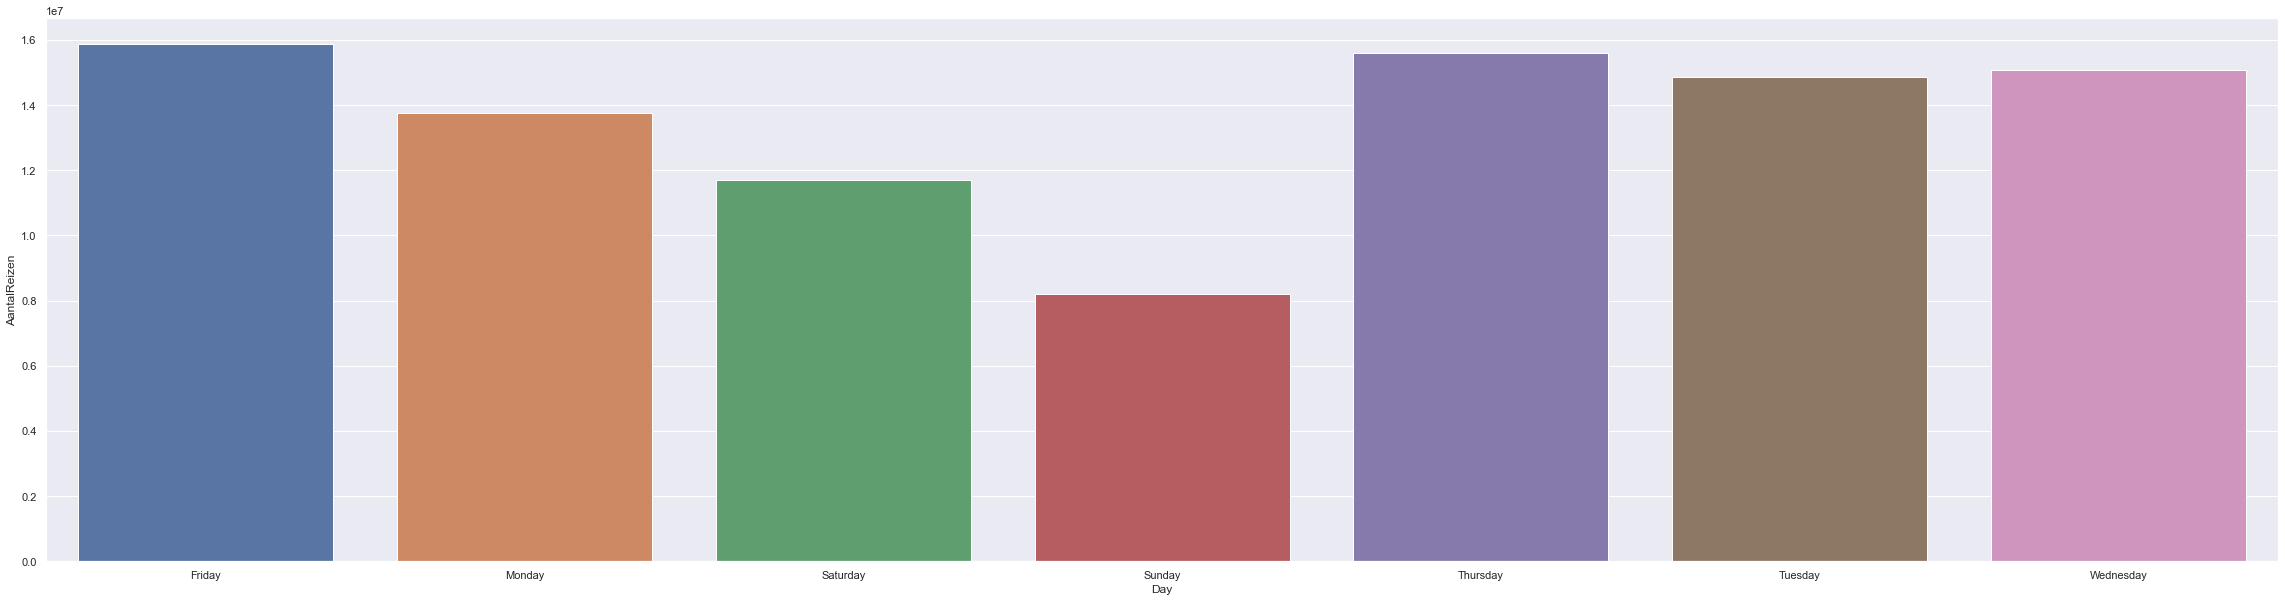

In [10]:
# Travels per day --> Sundays less public transport
gvb_data_range_very_cleaned_travellers_per_day['Day'] = gvb_data_range_very_cleaned_travellers_per_day[['Datum']].apply(lambda x: dt.datetime.strftime(x['Datum'], '%A'), axis=1)
range_summed_per_day = gvb_data_range_very_cleaned_travellers_per_day.groupby('Day').sum().reset_index()

plt.figure(figsize=(40,10))
sns.barplot(x="Day", y="AantalReizen", data=range_summed_per_day);


# Calculate stations near park

In [11]:
# Create DF with all stations with their lon and lat
stations_lon_lat = gvb_data_range_very_cleaned.drop_duplicates(subset=['AankomstHalteNaam'])[['AankomstHalteNaam', 'AankomstLon', 'AankomstLat']]
stations_lon_lat = stations_lon_lat.set_index('AankomstHalteNaam')
stations_lon_lat.rename(columns={"AankomstLat": "lng", "AankomstLon": "lat"}, inplace=True)
stations_lon_lat

,lat,lng
AankomstHalteNaam,,
Centraal Station,52.378108,4.899218
Station Diemen-Zuid,52.330428,4.957133
Station Lelylaan,52.357663,4.834266
Station Bijlmer ArenA,52.311930,4.947135
Bullewijk,52.306422,4.952336
...,...,...
Biesbosch,52.330738,4.946083
Durbanweg,52.407657,4.734370
Lorentzlaan,52.345829,4.931976


In [12]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def add_nearby_stations(radius, center_point_dict, add_to_list):
    """
    radius in km
    center_point_dict needs to be a dictionary with the lon and lat from a location
    add_to_list specify to which list this needs to be added (for example vondelpark)
    """
    latpark = center_point_dict[0]['lat']
    lonpark = center_point_dict[0]['lng']

    # check for every station if it is within 1 km distance of the park
    for station in range(len(stations_lon_lat)):
        name_station = stations_lon_lat.iloc[station].name
        latstation = stations_lon_lat.iloc[station].lat
        lonstation = stations_lon_lat.iloc[station].lng

        a = haversine(lonpark, latpark, lonstation, latstation)
        
        if a <= radius:
            add_to_list.append(name_station)

In [13]:
# Center points of all the parks (https://www.latlong.net/)
all_parks = ['vondelpark_west','vondelpark_oost_3','vondelpark_oost_2',
             'vondelpark_oost_1' 'oosterpark', 'sarphatipark',
            'westerpark_west','westerpark_oost','westerpark_centrum', 
             'westergasfabriek','rembrandtpark_noord', 'rembrandtpark_zuid', 
             'erasmuspark']

vondelpark_west = [{'lat': 52.356496, 'lng': 4.861447}]
vondelpark_oost_3 = [{'lng': 4.869217, 'lat': 52.358252}]
vondelpark_oost_2 = [{'lng': 4.874692, 'lat': 52.359798}]
vondelpark_oost_1 = [{'lng': 4.879652, 'lat': 52.360991}]
oosterpark = [{'lng': 4.920558, 'lat': 52.360098}]
sarphatipark = [{'lng': 4.896375, 'lat': 52.354364}]
westerpark_west = [{'lng': 4.867128, 'lat': 52.387099}]
westerpark_centrum = [{'lng': 4.873268, 'lat': 52.387374}]
westerpark_oost = [{'lng': 4.878379, 'lat': 52.386379}]
westergasfabriek = [{'lng': 4.869769, 'lat': 52.385920}]
rembrandtpark_noord = [{'lng': 4.846573, 'lat': 52.366664}]
rembrandtpark_zuid = [{'lng': 4.846932, 'lat': 52.361161}]
erasmuspark = [{'lng': 4.851909, 'lat': 52.374808}]

# Create empty list that needs to be filled later
vondelpark_west_stations = []
vondelpark_oost_3_stations = []
vondelpark_oost_2_stations = []
vondelpark_oost_1_stations = []
oosterpark_stations = []
sarphatipark_stations = []
westerpark_west_stations = []
westerpark_centrum_stations = []
westerpark_oost_stations = []
westergasfabriek_stations = []
rembrandtpark_noord_stations = []
rembrandtpark_zuid_stations = []
erasmuspark_stations = []

# calculate all stations within 1 km from the park
add_nearby_stations(1,vondelpark_west, vondelpark_west_stations)
add_nearby_stations(1,vondelpark_oost_3, vondelpark_oost_3_stations)
add_nearby_stations(1,vondelpark_oost_2, vondelpark_oost_2_stations)
add_nearby_stations(1,vondelpark_oost_1, vondelpark_oost_1_stations)
add_nearby_stations(1,oosterpark,oosterpark_stations)
add_nearby_stations(1,sarphatipark,sarphatipark_stations)
add_nearby_stations(1,westergasfabriek, westergasfabriek_stations)
add_nearby_stations(1,westerpark_west, westerpark_west_stations)
add_nearby_stations(1,westerpark_centrum, westerpark_centrum_stations)
add_nearby_stations(1,westerpark_oost, westerpark_oost_stations)
add_nearby_stations(1,rembrandtpark_noord,rembrandtpark_noord_stations)
add_nearby_stations(1,rembrandtpark_zuid,rembrandtpark_zuid_stations)
add_nearby_stations(1,erasmuspark,erasmuspark_stations)

In [14]:
# Example, stations near westerpark
rembrandtpark_noord_stations

['Postjesweg',
 'Jan v.Galenstraat',
 'Surinameplein',
 'Hoofdweg',
 'W. Schoutenstraat',
 'Jan Voermanstraat',
 'Mercatorplein',
 'Jan van Galenstraat',
 'Marco Polostraat',
 'Witte de Withstraat',
 'Jan Tooropstraat',
 'Adm. Helfrichstraat',
 'Nachtwachtlaan',
 'M. Bauerstraat',
 'J. Jongkindstraat',
 'Corantijnstraat']

In [67]:
gvb_data_range_very_cleaned

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen,count
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22,1
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139,1
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261,1
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205,1
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554,1
...,...,...,...,...,...,...,...,...
2664027,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31,1
2664028,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14,1
2664029,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20,1
2664020,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14,1


In [15]:
# day and time in one new column
gvb_data_range_travels = gvb_data_range_very_cleaned.copy()

gvb_data_range_travels['hour'] = gvb_data_range_travels['UurgroepOmschrijving (van aankomst)'].str[:5]
gvb_data_range_travels['hour'] = pd.to_datetime(gvb_data_range_travels['hour'], format='%H:%M').dt.time
gvb_data_range_travels['date'] = gvb_data_range_travels.apply(lambda r : pd.datetime.combine(r['Datum'],r['hour']),1)
gvb_data_range_travels = gvb_data_range_travels.set_index('date').reset_index()
gvb_data_range_travels = gvb_data_range_travels.drop(columns=['Datum', 'UurgroepOmschrijving (van aankomst)', 'AankomstHalteCode',
                                 'AankomstLat', 'AankomstLon', 'hour'])

gvb_data_range_travels


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,date,AankomstHalteNaam,AantalReizen
0,2020-10-01 00:00:00,Centraal Station,22
1,2020-10-01 16:00:00,Station Diemen-Zuid,139
2,2020-10-01 16:00:00,Centraal Station,1261
3,2020-10-01 16:00:00,Station Lelylaan,205
4,2020-10-01 16:00:00,Station Bijlmer ArenA,554
...,...,...,...
2138165,2021-12-19 13:00:00,Kattenburgerstraat,31
2138166,2021-12-19 13:00:00,Rietlandpark,14
2138167,2021-12-19 13:00:00,Rietlandpark,20
2138168,2021-12-19 13:00:00,Javaplein,14


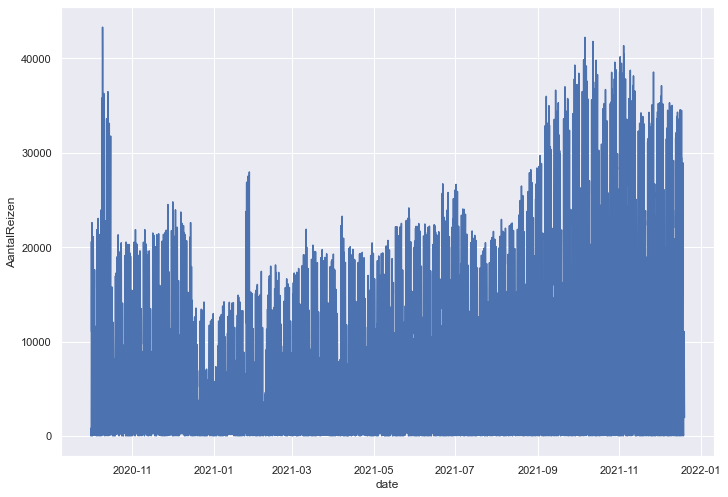

In [16]:
sns.lineplot(x="date", y="AantalReizen", data=gvb_data_range_travels.drop(columns=['AankomstHalteNaam']).groupby('date').sum());


In [17]:
vondelpark_west_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_west_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost1_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_oost_1_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost2_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_oost_2_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost3_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_oost_3_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
oosterpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(oosterpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
sarphatipark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(sarphatipark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_west_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westerpark_west_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_centrum_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westerpark_centrum_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_oost_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westerpark_oost_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westergasfabriek_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westergasfabriek_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandtpark_noord_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(rembrandtpark_noord_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandtpark_zuid_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(rembrandtpark_zuid_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
erasmuspark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(erasmuspark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()

# concatenate all dataframes into one, for later usage
vondelpark_west_journeys["park"] = 'vondelpark_west'
vondelpark_oost1_journeys["park"] = 'vondelpark_oost_1'
vondelpark_oost2_journeys["park"] = 'vondelpark_oost_2'
vondelpark_oost3_journeys["park"] = 'vondelpark_oost_3'
oosterpark_journeys["park"] = "oosterpark"
sarphatipark_journeys["park"] = "sarphatipark"
westerpark_west_journeys["park"] = "westerpark_west"
westerpark_oost_journeys["park"] = "westerpark_oost"
westerpark_centrum_journeys["park"] = "westerpark_centrum"
westergasfabriek_journeys["park"] = "westergasfabriek"
rembrandtpark_noord_journeys["park"] = "rembrandtpark_noord"
rembrandtpark_zuid_journeys["park"] = "rembrandtpark_zuid"
erasmuspark_journeys["park"] = "erasmuspark"

frames = [vondelpark_west_journeys, vondelpark_oost1_journeys, vondelpark_oost2_journeys, 
          vondelpark_oost3_journeys,oosterpark_journeys, sarphatipark_journeys, westerpark_west_journeys,
         westerpark_centrum_journeys, westerpark_oost_journeys, westergasfabriek_journeys,
         rembrandtpark_noord_journeys, rembrandtpark_zuid_journeys, erasmuspark_journeys]
all_parks_journeys = pd.concat(frames)


In [18]:
rembrandtpark_noord_journeys

,AantalReizen,park
date,,
2020-10-01 00:00:00,31,rembrandtpark_noord
2020-10-01 06:00:00,64,rembrandtpark_noord
2020-10-01 07:00:00,269,rembrandtpark_noord
2020-10-01 08:00:00,1036,rembrandtpark_noord
2020-10-01 09:00:00,798,rembrandtpark_noord
...,...,...
2021-12-19 19:00:00,212,rembrandtpark_noord
2021-12-19 20:00:00,184,rembrandtpark_noord
2021-12-19 21:00:00,145,rembrandtpark_noord


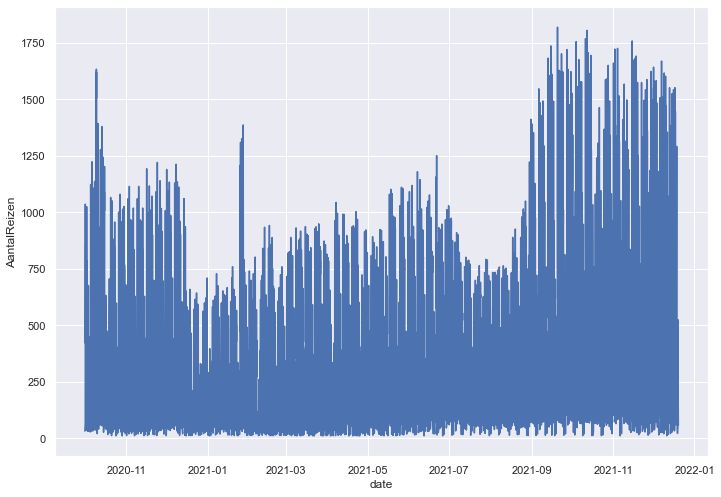

In [19]:
sns.lineplot(x="date", y="AantalReizen", data=rembrandtpark_noord_journeys.reset_index());

In [20]:
all_parks_journeys

,AantalReizen,park
date,,
2020-10-01 06:00:00,11,vondelpark_west
2020-10-01 07:00:00,106,vondelpark_west
2020-10-01 08:00:00,460,vondelpark_west
2020-10-01 09:00:00,443,vondelpark_west
2020-10-01 10:00:00,261,vondelpark_west
...,...,...
2021-12-19 19:00:00,78,erasmuspark
2021-12-19 20:00:00,140,erasmuspark
2021-12-19 21:00:00,133,erasmuspark


In [21]:
all_parks_journeys

,AantalReizen,park
date,,
2020-10-01 06:00:00,11,vondelpark_west
2020-10-01 07:00:00,106,vondelpark_west
2020-10-01 08:00:00,460,vondelpark_west
2020-10-01 09:00:00,443,vondelpark_west
2020-10-01 10:00:00,261,vondelpark_west
...,...,...
2021-12-19 19:00:00,78,erasmuspark
2021-12-19 20:00:00,140,erasmuspark
2021-12-19 21:00:00,133,erasmuspark


In [47]:
# Select Resono vondelpark data, make it (temporary) hourly to see the correlation with amount of journeys.
# Merge resono vondelpark data with gvb data. there are a lot of values that can not be matched, during the
# night trams do not run.

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list = []

for location in locations:
#     print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"resono_{location.lower()}"
    name = "_".join(name.split())

    
    parknaam= location.lower()
    parknaam = "_".join(parknaam.split())
    
    resono_park_list.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('End')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    df_resono_park_hourly = resono_park.resample('H').sum().drop(columns = ['Unnamed: 0'])
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_convert(None)
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_localize('utc') 
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == parknaam]
    gvb_park.index = gvb_park.index.tz_localize('utc')
    
    # merge gvb and resono to new dynamic df
    globals()[name] = df_resono_park_hourly.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

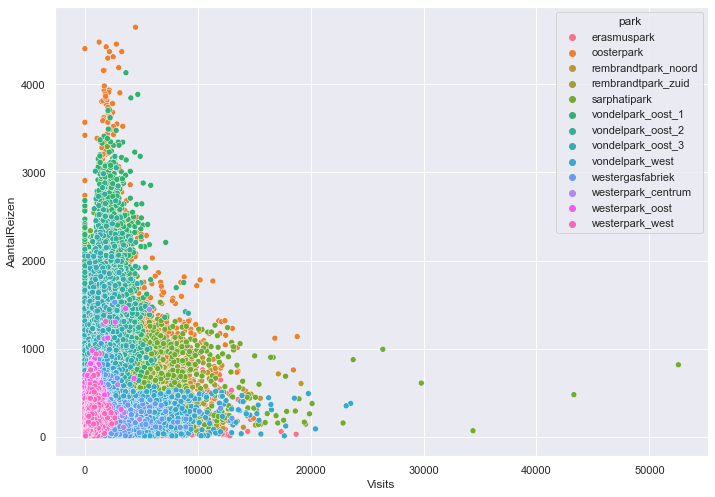

In [23]:
frames = [resono_erasmuspark, resono_oosterpark,resono_rembrandtpark_noord, resono_rembrandtpark_zuid,
         resono_sarphatipark,resono_vondelpark_oost_1,resono_vondelpark_oost_2, resono_vondelpark_oost_3,
         resono_vondelpark_west,resono_westergasfabriek, resono_westerpark, resono_westerpark_centrum, resono_westerpark_oost,
         resono_westerpark_west]

all_resono_park = pd.concat(frames)

sns.scatterplot(data=all_resono_park, x="Visits", y="AantalReizen", hue="park");

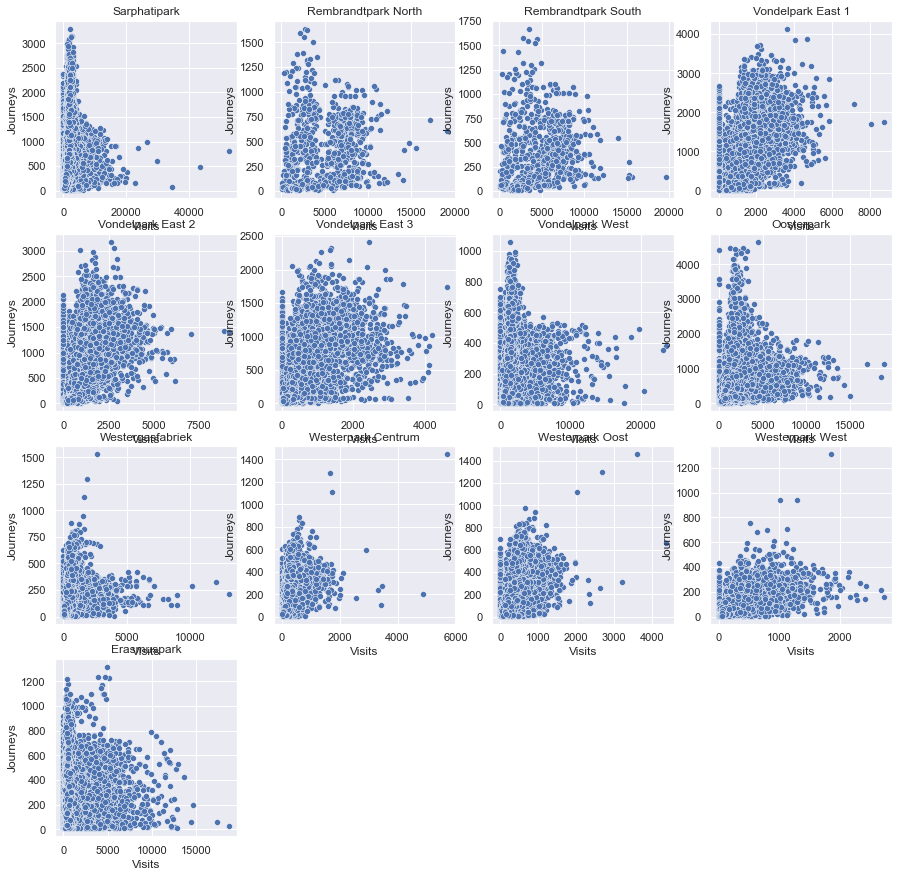

In [24]:
frames = [resono_erasmuspark, resono_oosterpark,resono_rembrandtpark_noord, resono_rembrandtpark_zuid,
         resono_sarphatipark,resono_vondelpark_oost_1,resono_vondelpark_oost_2, resono_vondelpark_oost_3,
         resono_vondelpark_west,resono_westergasfabriek, resono_westerpark, resono_westerpark_centrum, resono_westerpark_oost,
         resono_westerpark_west]

f, axes = plt.subplots(4, 4, figsize=(15, 15))

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_sarphatipark, ax=axes[0][0])
axes[0][0].set_title("Sarphatipark")
axes[0][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_rembrandtpark_noord, ax=axes[0][1])
axes[0][1].set_title("Rembrandtpark North")
axes[0][1].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_rembrandtpark_zuid, ax=axes[0][2])
axes[0][2].set_title("Rembrandtpark South")
axes[0][2].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_oost_1, ax=axes[0][3])
axes[0][3].set_title("Vondelpark East 1")
axes[0][3].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_oost_2, ax=axes[1][0])
axes[1][0].set_title("Vondelpark East 2")
axes[1][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_oost_3, ax=axes[1][1])
axes[1][1].set_title("Vondelpark East 3")
axes[1][1].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_vondelpark_west, ax=axes[1][2])
axes[1][2].set_title("Vondelpark West")
axes[1][2].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_oosterpark, ax=axes[1][3])
axes[1][3].set_title("Oosterpark")
axes[1][3].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_westergasfabriek, ax=axes[2][0])
axes[2][0].set_title("Westergasfabriek")
axes[2][0].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_westerpark_centrum, ax=axes[2][1])
axes[2][1].set_title("Westerpark Centrum")
axes[2][1].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_westerpark_oost, ax=axes[2][2])
axes[2][2].set_title("Westerpark Oost")
axes[2][2].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_westerpark_west, ax=axes[2][3])
axes[2][3].set_title("Westerpark West")
axes[2][3].set_ylabel("Journeys")

sns.scatterplot(x="Visits", y="AantalReizen", data=resono_erasmuspark, ax=axes[3][0])
axes[3][0].set_title("Erasmuspark")
axes[3][0].set_ylabel("Journeys")

axes[3,1].set_axis_off()
axes[3,2].set_axis_off()
axes[3,3].set_axis_off()

In [51]:
# Data transformations
all_resono_park['Journeys_normal'] = all_resono_park['AantalReizen']
all_resono_park['Journeys_log'] = np.log(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_squareroot'] = np.sqrt(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_cuberoot'] = np.cbrt(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_boxcox'] = stats.boxcox(all_resono_park['Journeys_normal'])[0]

all_resono_park

,Visits,AantalReizen,park,Journeys_interpolated,Journeys_normal,Journeys_log,Journeys_squareroot,Journeys_cuberoot,Journeys_boxcox
End,,,,,,,,,
2020-10-01 00:00:00,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 01:00:00,699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 02:00:00,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 03:00:00,492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 04:00:00,732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-01-06 10:00:00,572,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2022-01-06 11:00:00,700,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2022-01-06 12:00:00,509,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN


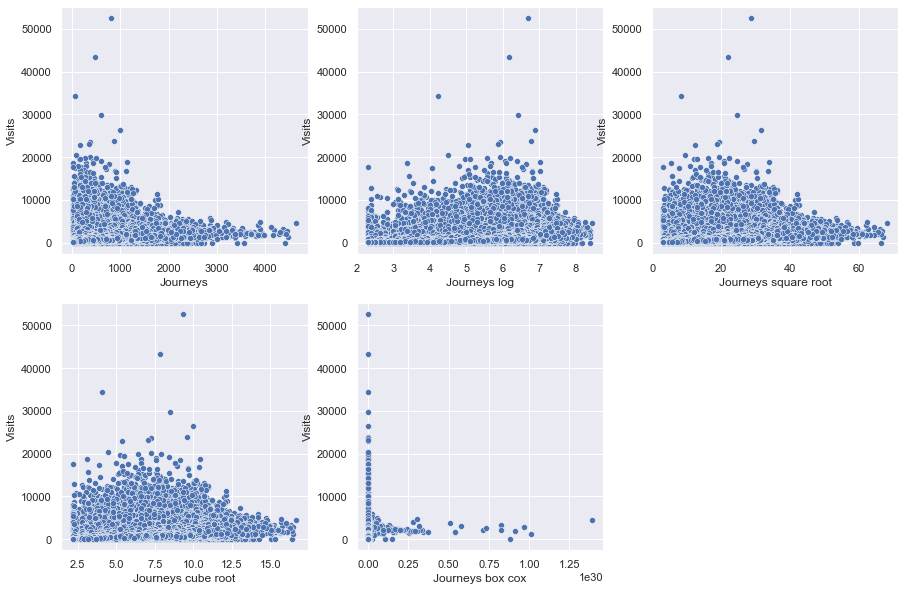

In [52]:
# Show all correlations between park and data transformated journeys 
f, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.scatterplot(x="Journeys_normal", y="Visits", data=all_resono_park, ax=axes[0][0])
axes[0][0].set_xlabel("Journeys")

sns.scatterplot(x="Journeys_log", y="Visits", data=all_resono_park, ax=axes[0][1])
axes[0][1].set_xlabel("Journeys log")

sns.scatterplot(x="Journeys_squareroot", y="Visits", data=all_resono_park, ax=axes[0][2])
axes[0][2].set_xlabel("Journeys square root")

sns.scatterplot(x="Journeys_cuberoot", y="Visits", data=all_resono_park, ax=axes[1][0])
axes[1][0].set_xlabel("Journeys cube root")

sns.scatterplot(x="Journeys_boxcox", y="Visits", data=all_resono_park, ax=axes[1][1])
axes[1][1].set_xlabel("Journeys box cox")

axes[1,2].set_axis_off()

In [25]:
# Make all GVB data 15 min
vondelpark_west_journeys_15min = vondelpark_west_journeys.resample('15T').pad()
vondelpark_west_journeys_15min['AantalReizen'] = vondelpark_west_journeys_15min['AantalReizen'] / 4
    
vondelpark_oost1_journeys_15min = vondelpark_oost1_journeys.resample('15T').pad()
vondelpark_oost1_journeys_15min['AantalReizen'] = vondelpark_oost1_journeys_15min['AantalReizen'] / 4

vondelpark_oost2_journeys_15min = vondelpark_oost2_journeys.resample('15T').pad()
vondelpark_oost2_journeys_15min['AantalReizen'] = vondelpark_oost2_journeys_15min['AantalReizen'] / 4

vondelpark_oost3_journeys_15min = vondelpark_oost3_journeys.resample('15T').pad()
vondelpark_oost3_journeys_15min['AantalReizen'] = vondelpark_oost3_journeys_15min['AantalReizen'] / 4

oosterpark_journeys_15min = oosterpark_journeys.resample('15T').pad()
oosterpark_journeys_15min['AantalReizen'] = oosterpark_journeys_15min['AantalReizen'] / 4

sarphatipark_journeys_15min = sarphatipark_journeys.resample('15T').pad()
sarphatipark_journeys_15min['AantalReizen'] = sarphatipark_journeys_15min['AantalReizen'] / 4

rembrandtpark_noord_journeys_15min = rembrandtpark_noord_journeys.resample('15T').pad()
rembrandtpark_noord_journeys_15min['AantalReizen'] = rembrandtpark_noord_journeys_15min['AantalReizen'] / 4

rembrandtpark_zuid_journeys_15min = rembrandtpark_zuid_journeys.resample('15T').pad()
rembrandtpark_zuid_journeys_15min['AantalReizen'] = rembrandtpark_zuid_journeys_15min['AantalReizen'] / 4

westerpark_centrum_journeys_15min = westerpark_centrum_journeys.resample('15T').pad()
westerpark_centrum_journeys_15min['AantalReizen'] = westerpark_centrum_journeys_15min['AantalReizen'] / 4

westerpark_oost_journeys_15min = westerpark_oost_journeys.resample('15T').pad()
westerpark_oost_journeys_15min['AantalReizen'] = westerpark_oost_journeys_15min['AantalReizen'] / 4

westerpark_west_journeys_15min = westerpark_west_journeys.resample('15T').pad()
westerpark_west_journeys_15min['AantalReizen'] = westerpark_west_journeys_15min['AantalReizen'] / 4

westergasfabriek_journeys_15min = westergasfabriek_journeys.resample('15T').pad()
westergasfabriek_journeys_15min['AantalReizen'] = westergasfabriek_journeys_15min['AantalReizen'] / 4

erasmuspark_journeys_15min = erasmuspark_journeys.resample('15T').pad()
erasmuspark_journeys_15min['AantalReizen'] = erasmuspark_journeys_15min['AantalReizen'] / 4

In [26]:
# Select Resono vondelpark data
# Make GVB data 15 minutes

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list_15min = []

for location in locations:
    print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"min15_resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list_15min.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('End')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    resono_park.index = resono_park.index.tz_convert(None)
    resono_park.index = resono_park.index.tz_localize('utc') 
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == location.split().pop(0).lower()]
    gvb_park.index = gvb_park.index.tz_localize('utc')

    # merge gvb and resono to new dynamic df
    globals()[name] = resono_park.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

Erasmuspark
Oosterpark
Rembrandtpark Noord
Rembrandtpark Zuid
Sarphatipark
Vondelpark Oost
Vondelpark Oost 1
Vondelpark Oost 2
Vondelpark Oost 3
Vondelpark West
Westergasfabriek
Westerpark
Westerpark Centrum
Westerpark Oost
Westerpark West


In [27]:
resono_park_list_15min

['min15_resono_erasmuspark',
 'min15_resono_oosterpark',
 'min15_resono_rembrandtpark_noord',
 'min15_resono_rembrandtpark_zuid',
 'min15_resono_sarphatipark',
 'min15_resono_vondelpark_oost',
 'min15_resono_vondelpark_oost_1',
 'min15_resono_vondelpark_oost_2',
 'min15_resono_vondelpark_oost_3',
 'min15_resono_vondelpark_west',
 'min15_resono_westergasfabriek',
 'min15_resono_westerpark',
 'min15_resono_westerpark_centrum',
 'min15_resono_westerpark_oost',
 'min15_resono_westerpark_west']

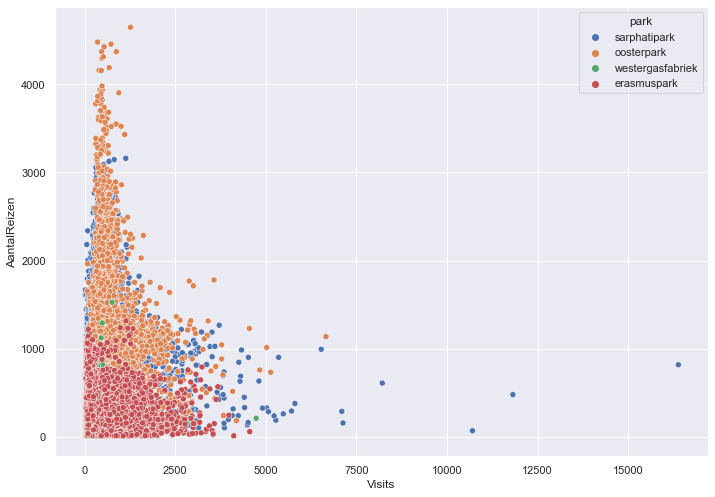

In [28]:
frames = [min15_resono_sarphatipark, min15_resono_rembrandtpark_noord, min15_resono_rembrandtpark_zuid,
         min15_resono_vondelpark_oost, min15_resono_vondelpark_west, min15_resono_oosterpark,
         min15_resono_westergasfabriek, min15_resono_erasmuspark]

min15_all_resono_park = pd.concat(frames)

sns.scatterplot(data=min15_all_resono_park, x="Visits", y="AantalReizen", hue="park");

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


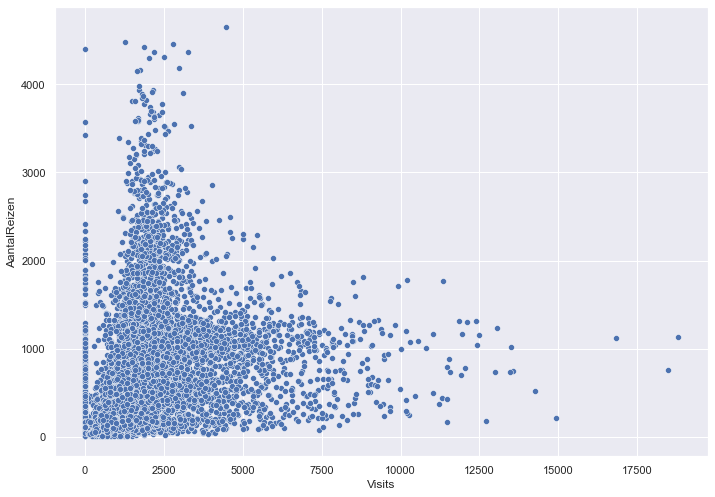

In [29]:
# CODE CAN BE REMOVED EVENTUALLY
resono_oosterpark = resono[resono['Location'] == 'Oosterpark']
resono_oosterpark['End'] = pd.to_datetime(resono_oosterpark['End'], utc=True)
resono_oosterpark = resono_oosterpark.set_index('End')

resono_oosterpark_hourly = resono_oosterpark.resample('H').sum().drop(columns = ['Unnamed: 0'])
resono_oosterpark_hourly.index = resono_oosterpark_hourly.index.tz_convert(None)

resonoXvisits_oosterpark = resono_oosterpark_hourly.loc["2020-10":].join(oosterpark_journeys)
resonoXvisits_oosterpark = resonoXvisits_oosterpark.dropna()
resonoXvisits_oosterpark

sns.scatterplot(data=resonoXvisits_oosterpark, x="Visits", y="AantalReizen");

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


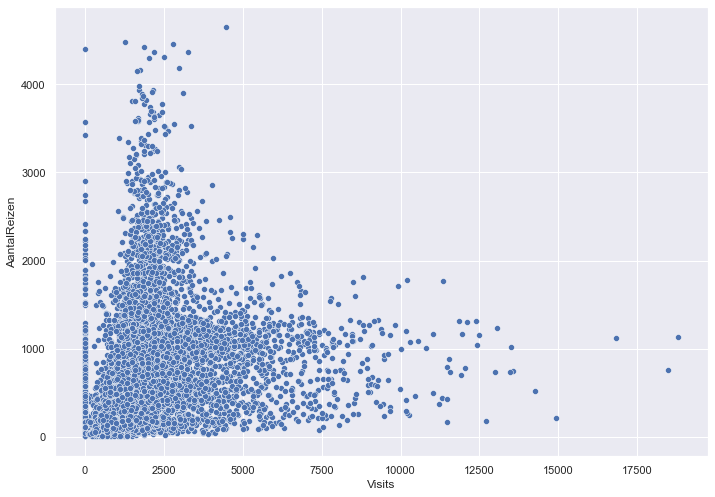

In [29]:
# CODE CAN BE REMOVED EVENTUALLY
resono_oosterpark = resono[resono['Location'] == 'Oosterpark']
resono_oosterpark['End'] = pd.to_datetime(resono_oosterpark['End'], utc=True)
resono_oosterpark = resono_oosterpark.set_index('End')

resono_oosterpark_hourly = resono_oosterpark.resample('H').sum().drop(columns = ['Unnamed: 0'])
resono_oosterpark_hourly.index = resono_oosterpark_hourly.index.tz_convert(None)

resonoXvisits_oosterpark = resono_oosterpark_hourly.loc["2020-10":].join(oosterpark_journeys)
resonoXvisits_oosterpark = resonoXvisits_oosterpark.dropna()
resonoXvisits_oosterpark

sns.scatterplot(data=resonoXvisits_oosterpark, x="Visits", y="AantalReizen");

In [45]:
min15_all_resono_park = min15_all_resono_park.drop(columns=['AantalReizen', 'park']).dropna()
min15_all_resono_park.to_csv("gvb_resono.csv")

,End,Location,Visits,End_Dates,End_Time,Journeys_interpolated
,,,,,,
92692,2020-10-01 06:00:00,Sarphatipark,224,2020-10-01,06:00:00,147.00
92693,2020-10-01 06:15:00,Sarphatipark,315,2020-10-01,06:15:00,229.75
92694,2020-10-01 06:30:00,Sarphatipark,367,2020-10-01,06:30:00,312.50
92695,2020-10-01 06:45:00,Sarphatipark,463,2020-10-01,06:45:00,395.25
92696,2020-10-01 07:00:00,Sarphatipark,631,2020-10-01,07:00:00,478.00
...,...,...,...,...,...,...
42123,2022-01-06 13:45:00,Erasmuspark,134,2022-01-06,13:45:00,36.00
42124,2022-01-06 14:00:00,Erasmuspark,165,2022-01-06,14:00:00,36.00
42125,2022-01-06 14:15:00,Erasmuspark,179,2022-01-06,14:15:00,36.00
